# Study Score Distribution for Sentinel-2 Macrolocalization Model Deployment

## Import required libraries

In [1]:
import os
import glob

import geopandas as gpd
import pandas as pd
import numpy as np

import boto3

from matplotlib import pyplot as plt

from IPython.display import clear_output

## Inputs and parameters

In [2]:
s3_path = 'S2-RGB-macro-localization-model-deployment4/'
consolidated_score_gjson = 'S2-deployment-chip-scores-CHN-10km-nowater-2020-consolidated.geojson'
s2_grid_gjson = '../../resources/macro-loc-model-deployment4/S2-deployment-grid-CHN-10km-nowater.geojson'
LOCAL_DIR = '/scratch/'

In [3]:
calc_crs = 'EPSG:3395'

In [4]:
s3 = boto3.resource('s3')
bucket = s3.Bucket('sfi-shared-assets')

## Outputs

In [5]:
deployment_data_path = '../../resources/macro-loc-model-deployment4/'
output_prefix = 'S2-deployment-CHN-10km-nowater-2020-'

cmt_hist_png = deployment_data_path+output_prefix+'cement-score-hist.png'
cmt_cum_hist_png = deployment_data_path+output_prefix+'cement-score-cum-hist.png'
stl_hist_png = deployment_data_path+output_prefix+'steel-score-hist.png'
stl_cum_hist_png = deployment_data_path+output_prefix+'steel-score-cum-hist.png'

## Download consolidated deployment results and read it in

In [6]:
bucket.download_file(s3_path+consolidated_score_gjson,
                     LOCAL_DIR+consolidated_score_gjson)

In [7]:
unq_chip_gdf = gpd.read_file(LOCAL_DIR+consolidated_score_gjson)

In [8]:
chp_cnt = len(unq_chip_gdf)
print('Number of chips: ', str(chp_cnt))

Number of chips:  415036


## Create histograms of probabilities of model scores

In [9]:
bedges = np.arange(0, 1.01, 0.01)

### Cement

In [10]:
cmt_prb_hist, bin_edges = np.histogram(unq_chip_gdf.tile_cmt_prob, 
                                       bins=bedges)

In [11]:
cmt_prob_knwn = unq_chip_gdf[~unq_chip_gdf.cmtv4p1_uid.isnull()]
cmt_knwn_prb_hist, bin_edges = np.histogram(cmt_prob_knwn.tile_cmt_prob, 
                                            bins=bedges)

### Steel

In [12]:
stl_prb_hist, bin_edges = np.histogram(unq_chip_gdf.tile_stl_prob, 
                                       bins=bedges)

In [13]:
stl_prob_knwn = unq_chip_gdf[~unq_chip_gdf.stlv4p1_uid.isnull()]
stl_knwn_prb_hist, bin_edges = np.histogram(stl_prob_knwn.tile_stl_prob, 
                                            bins=bedges)

In [14]:
model_prob_hist = pd.DataFrame({'bin_left_edge': bin_edges[:-1],
                                'cmt_prb_hist': cmt_prb_hist,
                                'cmt_knwn_prb_hist': cmt_knwn_prb_hist,
                                'stl_prb_hist': stl_prb_hist,
                                'stl_knwn_prb_hist': stl_knwn_prb_hist})

In [15]:
model_prob_hist['cmt_prb_cumsum'] = model_prob_hist.cmt_prb_hist.cumsum()
model_prob_hist['stl_prb_cumsum'] = model_prob_hist.stl_prb_hist.cumsum()
model_prob_hist['cmt_knwn_prb_cumsum'] = model_prob_hist.cmt_knwn_prb_hist.cumsum()
model_prob_hist['stl_knwn_prb_cumsum'] = model_prob_hist.stl_knwn_prb_hist.cumsum()

## Plot histograms

### Cement

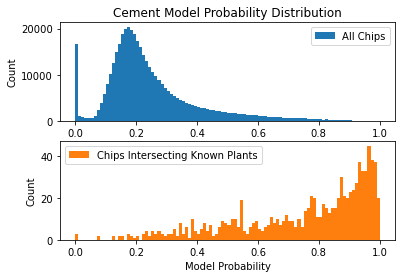

In [16]:
fig, (ax1, ax2) = plt.subplots(2, sharey=False)

ax1.bar(x=model_prob_hist.bin_left_edge,
        height=model_prob_hist.cmt_prb_hist,
        align='edge',
        width=0.01,
        label='All Chips')
ax1.set(title='Cement Model Probability Distribution', ylabel='Count')
ax1.legend()

ax2.bar(x=model_prob_hist.bin_left_edge,
        height=model_prob_hist.cmt_knwn_prb_hist,
        align='edge',
        width=0.01,
        color='tab:orange',
        label='Chips Intersecting Known Plants')
ax2.set(ylabel='Count', xlabel='Model Probability')
ax2.legend()

fig.savefig(cmt_hist_png)
plt.show()

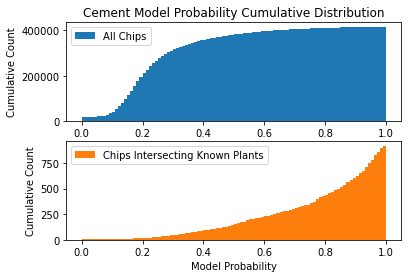

In [17]:
fig, (ax1, ax2) = plt.subplots(2, sharey=False)

ax1.bar(x=model_prob_hist.bin_left_edge,
        height=model_prob_hist.cmt_prb_cumsum,
        align='edge',
        width=0.01,
        label='All Chips')
ax1.set(title='Cement Model Probability Cumulative Distribution', 
        ylabel='Cumulative Count')
ax1.legend()

ax2.bar(x=model_prob_hist.bin_left_edge,
        height=model_prob_hist.cmt_knwn_prb_cumsum,
        align='edge',
        width=0.01,
        color='tab:orange',
        label='Chips Intersecting Known Plants')
ax2.set(ylabel='Cumulative Count', xlabel='Model Probability')
ax2.legend()

fig.savefig(cmt_cum_hist_png)
plt.show()

In [18]:
cmt_thr1000 = model_prob_hist.loc[(model_prob_hist.cmt_prb_cumsum - 
                            (model_prob_hist.cmt_prb_cumsum.max()-1000)).abs().idxmin()]
print('Cement probability threshold to grab top 1000:', cmt_thr1000.bin_left_edge)

Cement probability threshold to grab top 1000: 0.89


In [46]:
cmt_thresh = 0.58
cmt_recall = (sum(model_prob_hist.cmt_knwn_prb_hist) - \
                 model_prob_hist.loc[np.round(model_prob_hist.bin_left_edge,2) == cmt_thresh].cmt_knwn_prb_cumsum) / \
                 sum(model_prob_hist.cmt_knwn_prb_hist)
cmt_chp_cnt = (sum(model_prob_hist.cmt_prb_hist) - \
                 model_prob_hist.loc[np.round(model_prob_hist.bin_left_edge,2) == cmt_thresh].cmt_prb_cumsum)

In [47]:
print('Actual Cement Recall on Deployment: ', cmt_recall.tolist()[0])
print('Count of Chips with Score > ', cmt_thresh, ': ', cmt_chp_cnt.tolist()[0])
print('Number of cement plants in deployment region: ', sum(model_prob_hist.cmt_knwn_prb_hist))

Actual Cement Recall on Deployment:  0.7641304347826087
Count of Chips with Score >  0.58 :  20087
Number of cement plants in deployment region:  920


### Steel

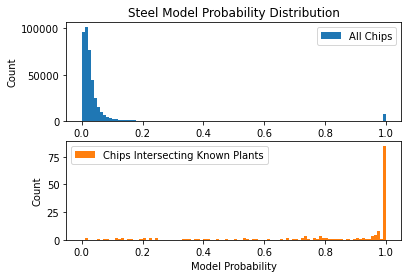

In [37]:
fig, (ax1, ax2) = plt.subplots(2, sharey=False)

ax1.bar(x=model_prob_hist.bin_left_edge,
        height=model_prob_hist.stl_prb_hist,
        align='edge',
        width=0.01,
        label='All Chips')
ax1.set(title='Steel Model Probability Distribution', ylabel='Count')
ax1.legend()

ax2.bar(x=model_prob_hist.bin_left_edge,
        height=model_prob_hist.stl_knwn_prb_hist,
        align='edge',
        width=0.01,
        color='tab:orange',
        label='Chips Intersecting Known Plants')
ax2.set(ylabel='Count', xlabel='Model Probability')
ax2.legend()

fig.savefig(stl_hist_png)
plt.show()

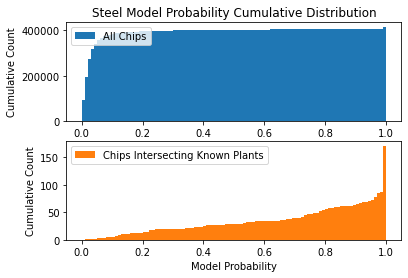

In [38]:
fig, (ax1, ax2) = plt.subplots(2, sharey=False)

ax1.bar(x=model_prob_hist.bin_left_edge,
        height=model_prob_hist.stl_prb_cumsum,
        align='edge',
        width=0.01,
        label='All Chips')
ax1.set(title='Steel Model Probability Cumulative Distribution', 
        ylabel='Cumulative Count')
ax1.legend()

ax2.bar(x=model_prob_hist.bin_left_edge,
        height=model_prob_hist.stl_knwn_prb_cumsum,
        align='edge',
        width=0.01,
        color='tab:orange',
        label='Chips Intersecting Known Plants')
ax2.set(ylabel='Cumulative Count', xlabel='Model Probability')
ax2.legend()

fig.savefig(stl_cum_hist_png)
plt.show()

In [39]:
stl_thr1000 = model_prob_hist.loc[(model_prob_hist.stl_prb_cumsum - 
                            (model_prob_hist.stl_prb_cumsum.max()-1000)).abs().idxmin()]
print('Steel probability threshold to grab top 1000:', stl_thr1000.bin_left_edge)

Steel probability threshold to grab top 1000: 0.99


In [44]:
stl_thresh = 0.95
stl_recall = (sum(model_prob_hist.stl_knwn_prb_hist) - \
                 model_prob_hist.loc[np.round(model_prob_hist.bin_left_edge,2) == stl_thresh].stl_knwn_prb_cumsum) / \
                 sum(model_prob_hist.stl_knwn_prb_hist)
stl_chp_cnt = (sum(model_prob_hist.stl_prb_hist) - \
                 model_prob_hist.loc[np.round(model_prob_hist.bin_left_edge,2) == stl_thresh].stl_prb_cumsum)

In [45]:
print('Steel Recall on Deployment: ', stl_recall.tolist()[0])
print('Count of Chips with Score > ', stl_thresh, ': ', stl_chp_cnt.tolist()[0])
print('Number of steel plants in deployment region: ', sum(model_prob_hist.stl_knwn_prb_hist))

Steel Recall on Deployment:  0.5730994152046783
Count of Chips with Score >  0.95 :  8395
Number of steel plants in deployment region:  171
